# Model Iterations
## Goal of Notebook
 - Because the sale price and square footage info (both total living space and lot size) are skewed to the right, this notebook runs various iterations comparing various transforms of these values to determine the most appropriate base model
 - This notebook also considers YrBuilt to determine whether to add it to the base model

##  Conclusion
 - Based on the models run, my base model will use the square root of the sales info, square root of the total living space, and square root of the lot size

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import sys
sys.path.append('../../')
import src.functions as fx

In [2]:
LookUp = pd.read_csv('../../data/raw/EXTR_LookUp.csv')
Parcel = pd.read_csv('../../data/raw/EXTR_Parcel.csv', dtype = str)
ResBldg = pd.read_csv('../../data/raw/EXTR_ResBldg.csv', dtype = str)
RPSale = pd.read_csv('../../data/raw/EXTR_RPSale.csv', dtype = str)

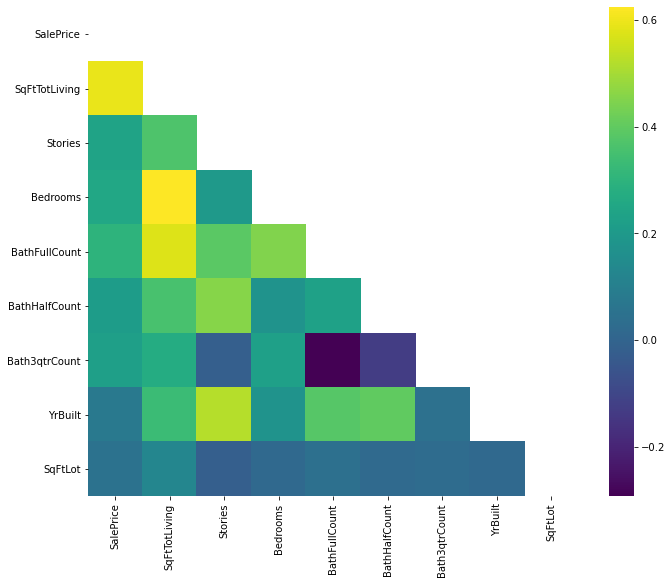

In [3]:
# According to the notes, Residential buildings are classified as
# buildings with 1, 2 or 3 living units
# Therefore, drop entries where NbrLivingUnits is not 1, 2 or 3
ResBldg = ResBldg[(ResBldg.NbrLivingUnits =='1') |
                  (ResBldg.NbrLivingUnits =='2') |
                  (ResBldg.NbrLivingUnits =='3')]

## Consider removing from this notebook
# Categorize Enclosed vs. Open Porches
# ResBldg.loc[ResBldg.SqFtOpenPorch == '0', 'porch'] = 'enclosed'
# ResBldg.loc[ResBldg.SqFtEnclosedPorch == '0', 'porch'] = 'open'
# ResBldg.loc[(ResBldg.SqFtOpenPorch == '0') & 
#             (ResBldg.SqFtEnclosedPorch == '0'), 'porch'] = 'none'
# ResBldg.loc[(ResBldg.SqFtOpenPorch != '0') & 
#             (ResBldg.SqFtEnclosedPorch != '0'), 'porch'] = 'both'


# Create ID to merge dataframes
RPSale.Major = RPSale.Major + RPSale.Minor
RPSale.rename(columns = {'Major':'ID'}, inplace=True)
RPSale = RPSale[['ID', 'SalePrice', 'PropertyType', 'PrincipalUse']]

ResBldg.Major = ResBldg.Major + ResBldg.Minor
ResBldg.rename(columns={'Major':'ID'}, inplace=True)
ResBldg = ResBldg[['ID', 'SqFtTotLiving', 'Stories', 'Bedrooms', 
                   'BathFullCount', 'BathHalfCount', 'Bath3qtrCount', 
                   'YrBuilt']]


Parcel.Major = Parcel.Major + Parcel.Minor
Parcel.rename(columns = {'Major':'ID'}, inplace = True)
Parcel = Parcel[['ID', 'SqFtLot']]

# Create lookup table for property type in RPSale
PropTypeKey = LookUp[LookUp.LUType == 1]

# Merge dataframes
ResSale = pd.merge(RPSale, ResBldg, on = 'ID', how = 'inner')
ResSale = pd.merge(ResSale, Parcel, on = 'ID', how = 'left')
ResSale = ResSale.astype({'SalePrice':int, 'PropertyType':int, 
                          'SqFtTotLiving':int, 'Stories':float, 
                          'Bedrooms':int, 'BathFullCount':int, 
                          'BathHalfCount':int, 'Bath3qtrCount':int, 
                          'YrBuilt':int, 'SqFtLot':int})

ResSale = pd.merge(ResSale, PropTypeKey, left_on = 'PropertyType', 
                   right_on = 'LUItem', how = 'left')
ResSale = ResSale.drop(columns=['ID', 'PropertyType', 'LUType', 'LUItem'])

# Only keep entries that relate to residential properties
ResSale2 = ResSale[ResSale.LUDescription.str.contains('single family', 
                                                      na=False)]
ResSale3 = ResSale[ResSale.LUDescription.str.contains('residence', 
                                                      na=False)]
ResSale4 = ResSale[ResSale.LUDescription.str.contains('Residential condo', 
                                                      na=False)]
ResSale5 = ResSale[ResSale.LUDescription.str.contains('other residential', 
                                                      na=False)]
ResSale = pd.concat([ResSale2, ResSale3, ResSale4, ResSale5])
ResSale = ResSale[ResSale.PrincipalUse == '6']
ResSale = ResSale.drop(columns = ['PrincipalUse', 'LUDescription'])

# Drop low outliers for sale price
ResSale = ResSale[ResSale.SalePrice > 32500]
# Drop low outliers for Square Footage
ResSale = ResSale[ResSale.SqFtTotLiving > 200]

# Look for variables that are highly correlated
corr = ResSale.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11,9))
sns_plot = sns.heatmap(corr, mask=mask, ax=ax1, cmap='viridis')
sns_plot.figure.savefig('../../reports/figures/heatmap.png')

### Note:
 - According to the heat map, living space (SqFtTotLiving) is the most highly correlated with SalePrice, and YrBuilt and lot size (SqFtLot) are the least correlated with SalePrice
 - Number of bedrooms and full bath counts appear to be highly correlated to living space, so if I include living space in my model, I will not proceed with the number of bedrooms and full bath counts
 - YrBuilt also appears to be somewhat correlated with living space, but since it is negatively correlated with sale price, I plan to check the affect of this variable in my model

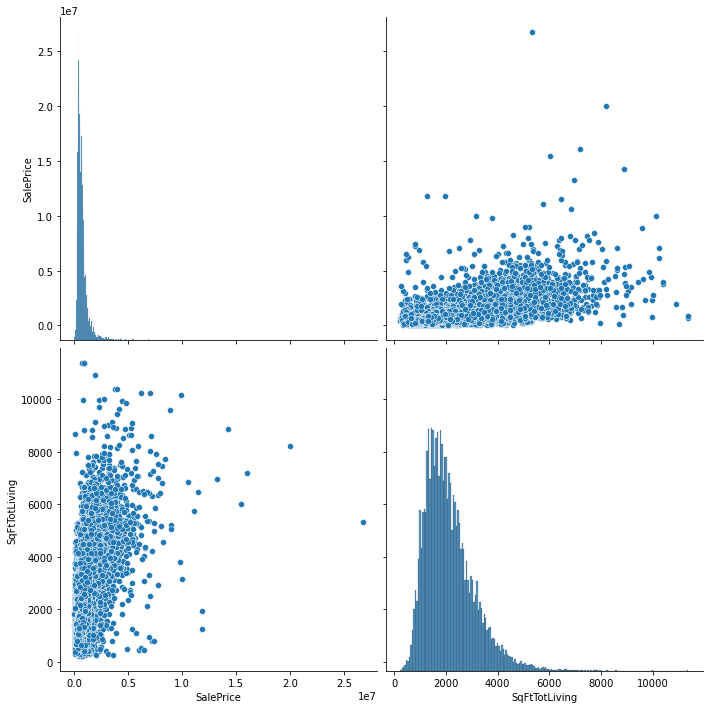

In [4]:
# Pair plot of sale price and living space
positively_correlated_cols = ['SalePrice', 'SqFtTotLiving']
positively_correlated_df = ResSale[positively_correlated_cols]
sns.pairplot(positively_correlated_df, height=5);

### Note:
Scatterplot indicates that the following extremes should be removed:
 - high sales price with low square footage
 - low sales price with high square footage

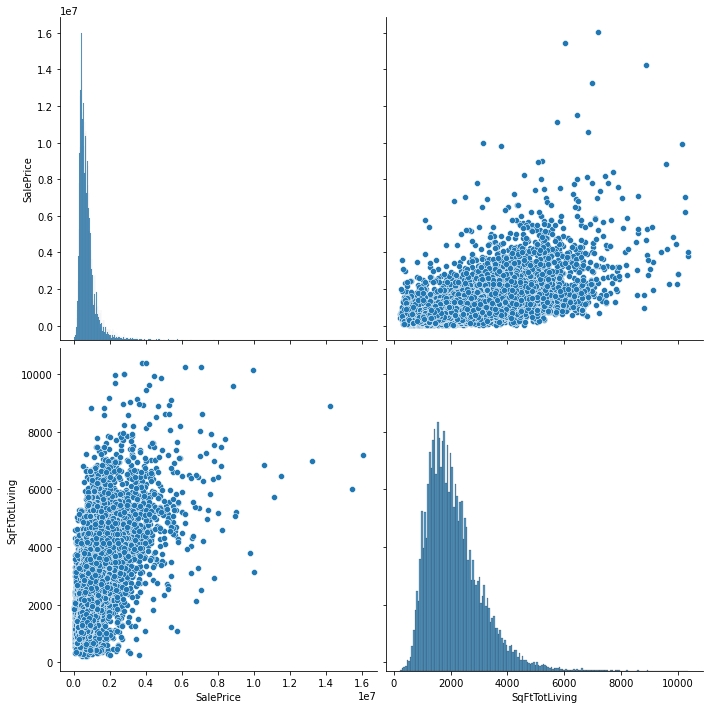

In [5]:
# shave off extremes (high sales price with low square footage
# and low sales prices with high square footage)
ResSale = ResSale[(ResSale.SalePrice < 4000000) |
                  (ResSale.SqFtTotLiving > 1000)]
ResSale = ResSale[(ResSale.SalePrice < 9000000) |
                  (ResSale.SqFtTotLiving > 2000)]
ResSale = ResSale[(ResSale.SalePrice < 20000000)]
ResSale = ResSale[(ResSale.SalePrice > 2250000) |
                  (ResSale.SqFtTotLiving < 10000)]
ResSale = ResSale[(ResSale.SalePrice > 1000000) |
                  (ResSale.SqFtTotLiving < 9000)]
ResSale = ResSale[(ResSale.SalePrice > 250000) |
                  (ResSale.SqFtTotLiving < 7500)]
ResSale = ResSale[(ResSale.SalePrice > 2500) |
                  (ResSale.SqFtTotLiving < 5000)]
positively_correlated_df = ResSale[positively_correlated_cols]
sns.pairplot(positively_correlated_df, height=5);

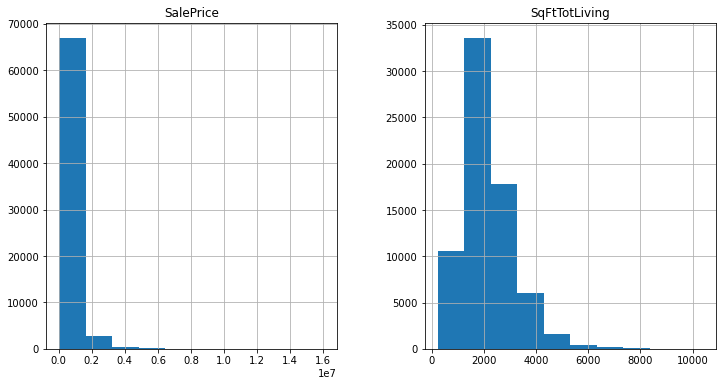

In [6]:
ResSale.hist(column = ['SalePrice', 'SqFtTotLiving'], figsize = [12, 6])
plt.savefig('../../reports/figures/histogram_pretransform.png')

### Note:
 - Sales price and square foot living space are both skewed to the right
 - Will try log transformation and square root

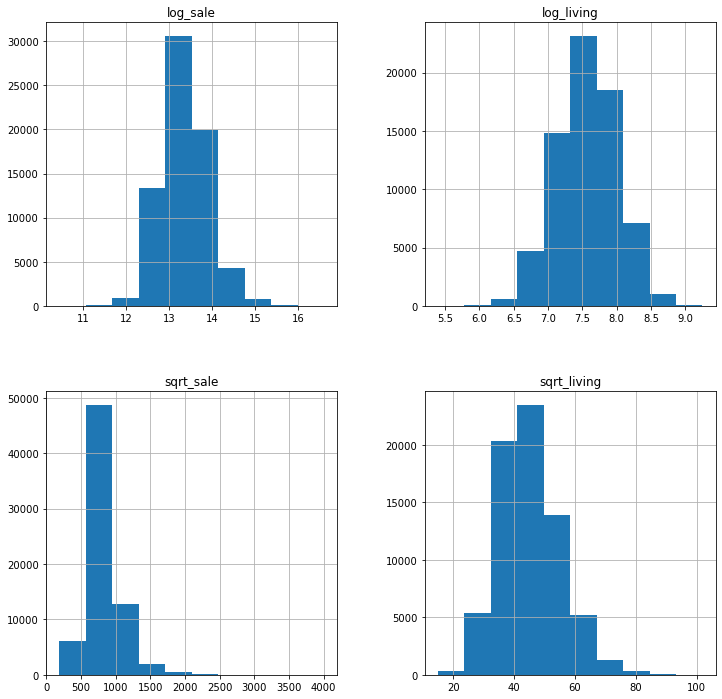

In [7]:
# Log transform of data
ResSale['log_sale'] = np.log(ResSale.SalePrice)
ResSale['log_living'] = np.log(ResSale.SqFtTotLiving)

# SQRT of data
ResSale['sqrt_sale'] = np.sqrt(ResSale.SalePrice)
ResSale['sqrt_living'] = np.sqrt(ResSale.SqFtTotLiving)

ResSale.hist(column = ['log_sale', 'log_living', 
                       'sqrt_sale', 'sqrt_living'],
                      figsize = [12, 12]);
plt.savefig('../../reports/figures/histogram_transformed.png')

### Note:
 - Log appears to make data more normally distributed
 - Square root of living square footage also appears to make data more normally distributed
 
# First Baseline Model: Sale Price with Total Living Space
 - Will run all iterations to determine best base model

## Sale Price with no transformation

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                 4.266e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:55:17   Log-Likelihood:            -1.0090e+06
No. Observations:               70192   AIC:                         2.018e+06
Df Residuals:                   70190   BIC:                         2.018e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.375e+04   3861.658      3.560

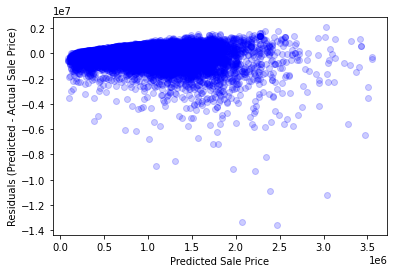

In [8]:
y = 'SalePrice'
X = ['SqFtTotLiving']
fx.create_model(ResSale, y, X)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                 2.691e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:55:19   Log-Likelihood:            -1.0143e+06
No. Observations:               70192   AIC:                         2.029e+06
Df Residuals:                   70190   BIC:                         2.029e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -4.1e+06   2.96e+04   -138.740      0.0

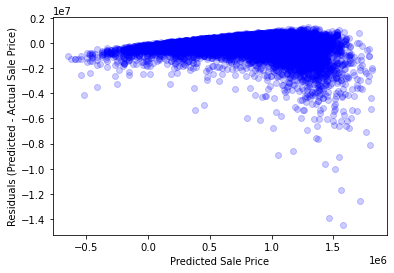

In [9]:
y = 'SalePrice'
X = ['log_living']
fx.create_model(ResSale, y, X)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                 3.491e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:55:23   Log-Likelihood:            -1.0115e+06
No. Observations:               70192   AIC:                         2.023e+06
Df Residuals:                   70190   BIC:                         2.023e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.591e+05   7667.680    -85.963      

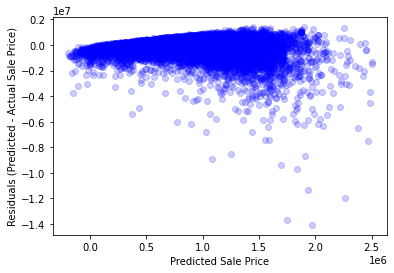

In [10]:
y = 'SalePrice'
X = ['sqrt_living']
fx.create_model(ResSale, y, X)

### Notes re untransformed sale price models:
 - All models are statistically significant and have coefficients that are statistically significant
 - The only model that meets any of the assumptions of linear regression is the log of the living space, but it shows a very negative intercept with a very high coefficient for log of living space
 - Square root of living space also shows a very negative intercept with a very high coefficient for log of living space
 - This model is not ideal
 
## Log Sales Price

                            OLS Regression Results                            
Dep. Variable:               log_sale   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                 4.292e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:55:27   Log-Likelihood:                -39950.
No. Observations:               70192   AIC:                         7.990e+04
Df Residuals:                   70190   BIC:                         7.992e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.6177      0.004   3237.382

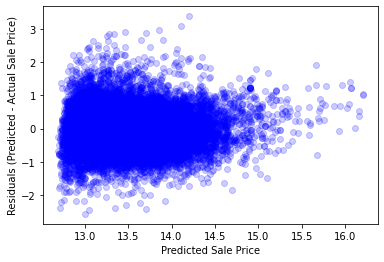

In [11]:
y = 'log_sale'
X = ['SqFtTotLiving']
fx.create_model(ResSale, y, X)

                            OLS Regression Results                            
Dep. Variable:               log_sale   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                 3.616e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:55:27   Log-Likelihood:                -42112.
No. Observations:               70192   AIC:                         8.423e+04
Df Residuals:                   70190   BIC:                         8.425e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9360      0.029    278.125      0.0

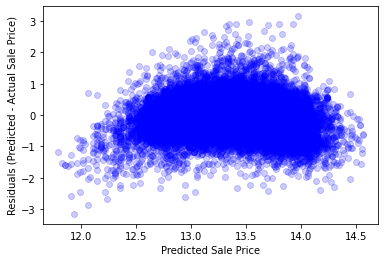

In [12]:
y = 'log_sale'
X = ['log_living']
fx.create_model(ResSale, y, X)

                            OLS Regression Results                            
Dep. Variable:               log_sale   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                 4.112e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:55:28   Log-Likelihood:                -40511.
No. Observations:               70192   AIC:                         8.103e+04
Df Residuals:                   70190   BIC:                         8.104e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      11.8620      0.008   1575.622      

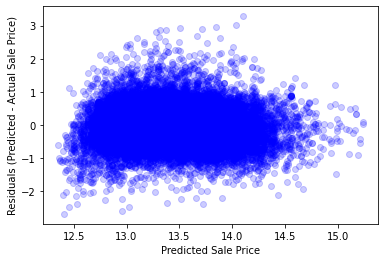

In [13]:
y = 'log_sale'
X = ['sqrt_living']
fx.create_model(ResSale, y, X)

### Notes re log sale price models:
 - All models are statistically significant and have coefficients that are statistically significant
 - All models meet the linearity assumption
 - Untransformed living space and square root of living space have a very small coefficient, so their impact on sale price is too insignificant to be worthwhile
 - Log of sale price with log of living space is a potentially good model


## Square Root Sales Price

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                 4.932e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:55:30   Log-Likelihood:            -4.6714e+05
No. Observations:               70192   AIC:                         9.343e+05
Df Residuals:                   70190   BIC:                         9.343e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       477.9394      1.714    278.891

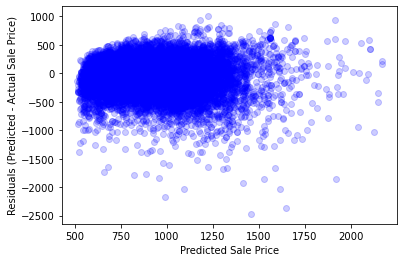

In [14]:
y = 'sqrt_sale'
X = ['SqFtTotLiving']
fx.create_model(ResSale, y, X)

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                 3.561e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:55:30   Log-Likelihood:            -4.7142e+05
No. Observations:               70192   AIC:                         9.428e+05
Df Residuals:                   70190   BIC:                         9.429e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1611.3731     12.930   -124.620      0.0

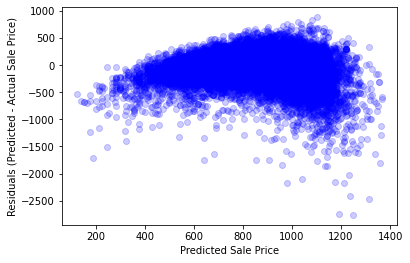

In [15]:
y = 'sqrt_sale'
X = ['log_living']
fx.create_model(ResSale, y, X)

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                 4.357e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:55:31   Log-Likelihood:            -4.6888e+05
No. Observations:               70192   AIC:                         9.378e+05
Df Residuals:                   70190   BIC:                         9.378e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     138.3937      3.366     41.116      

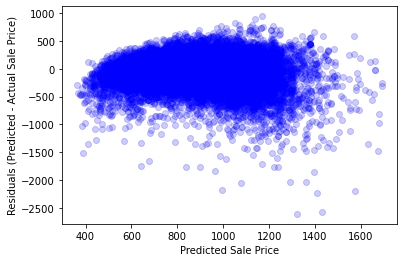

In [16]:
y = 'sqrt_sale'
X = ['sqrt_living']
fx.create_model(ResSale, y, X)

### Notes re square root sale price models:
 - All models are statistically significant and have coefficients that are statistically significant
 - All models meet the linearity assumption
 - Untransformed living space has a very small coefficient, so its impact on sale price is too insignificant to be worthwhile
 - Log of living space shows negative intercept with a very high coefficient for log of living space
 - Square root of both sale price and living space appears to be a good model, and it explains 38.3% of the variance in Sale Price, greater than log of both variables
 - Will proceed with square root of both sale price and living space
 
## Base Model Evaluation (square root of both sale price and living space)
$ \sqrt{sale price} = {\beta}_{0} + {\beta}_{1}\sqrt{living}$
 - R-squared is 0.383, so the model explains 38.3% of the variance in Sale Price
 - Overall p-value is 0.00, so the model is statistically significant at an alpha of 0.05
 - Property with 0 square feet of living space (i.e., just the land) is expected to sell for \$19,153
     - Note: since the model uses the square root of sale price, the intercept was squared to determine this value
 - For each additional square footage of living space, we expect the sale price to increase by \$232
     - because each additional square root of living space increases the square root of the sales price by \$15.2275
 - p-values for intercept and slope are significant at an alpha of 0.05.  Thus, this model finds that the relationship between sale price and square footage of living space is significant

### Assumptions of Linear Regression:
***Linearity***
The null hypothesis is that the model is linearly predicted by the features.  The alternative hypothesis is that it is not.  Thus returning a high Rainbow p-value means that the current model does not violate the linearity assumption

***Normality***
The null hypothesis is that the residuals are normally distributed.  The alternative hypothesis is that they are not.  Thus returning a p-value of 0 under the Jarque-Bera test means that the current model violates the normality assumption.

***Homoscadasticity***
The null hypothesis is homoscedasticity.  The alternative hypothesis is heteroscedasticity.  Thus returning a low F-statistic p-value means that the current model violates the homoscedasticity assumption.

***Independence***
Since we currently only have one independent variable, independence is not an issue.


# Second Baseline Model:
 - Will add negatively correlated variables to square root sale price and square root living space

In [17]:
ResSale = ResSale.drop(columns=['SalePrice', 'SqFtTotLiving', 
                                'log_sale', 'log_living'])
# Reorder so sqrt_sale is first column
cols = list(ResSale.columns)
cols = cols[7:9] + cols[:7]
cols
ResSale = ResSale[cols]
ResSale

,sqrt_sale,sqrt_living,Stories,Bedrooms,BathFullCount,BathHalfCount,Bath3qtrCount,YrBuilt,SqFtLot
11,748.331477,43.931765,1.0,3,2,0,0,1989,10523
12,659.545298,44.440972,2.0,3,1,0,2,1994,7392
17,632.455532,56.391489,1.0,6,1,0,2,1965,64033
19,721.110255,37.148351,1.5,3,1,0,1,1952,7930
21,651.920241,44.609416,2.0,3,2,1,0,2012,3547
...,...,...,...,...,...,...,...,...,...
210249,509.901951,28.460499,1.0,2,1,0,0,1909,3000
211262,930.053762,39.115214,3.0,3,1,1,1,2013,1077
231950,866.025404,37.549967,2.0,2,1,1,1,2012,1330
235714,938.083152,36.193922,2.0,2,2,1,0,2004,2499


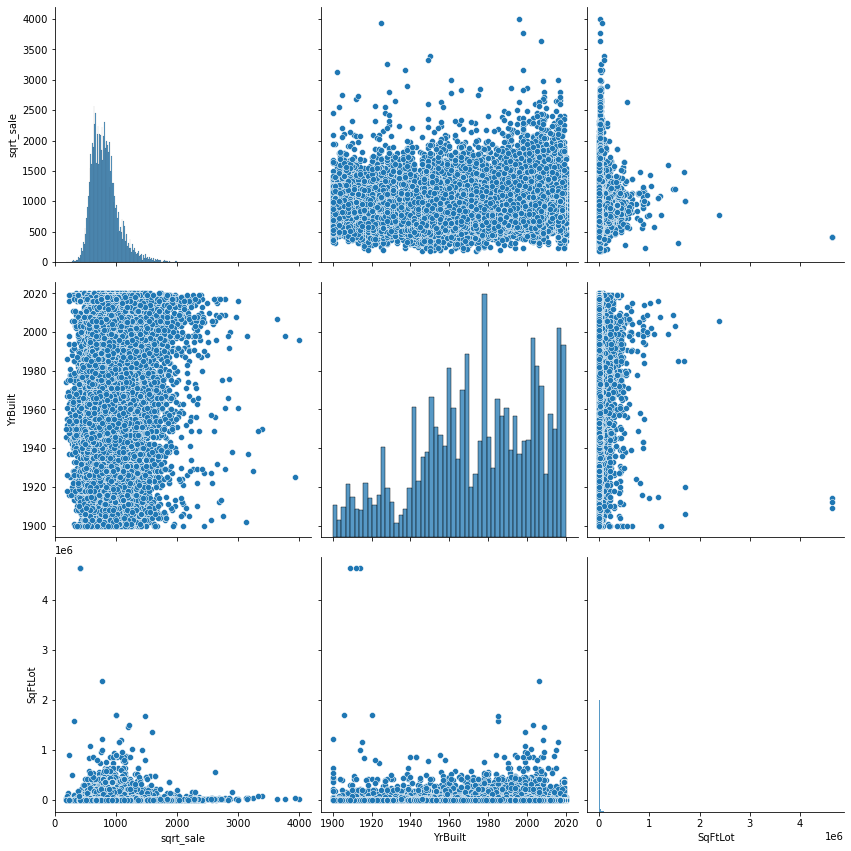

In [18]:
negatively_correlated_cols = ['sqrt_sale', 'YrBuilt', 'SqFtLot']
negatively_correlated_df = ResSale[negatively_correlated_cols]
sns.pairplot(negatively_correlated_df, height=4);

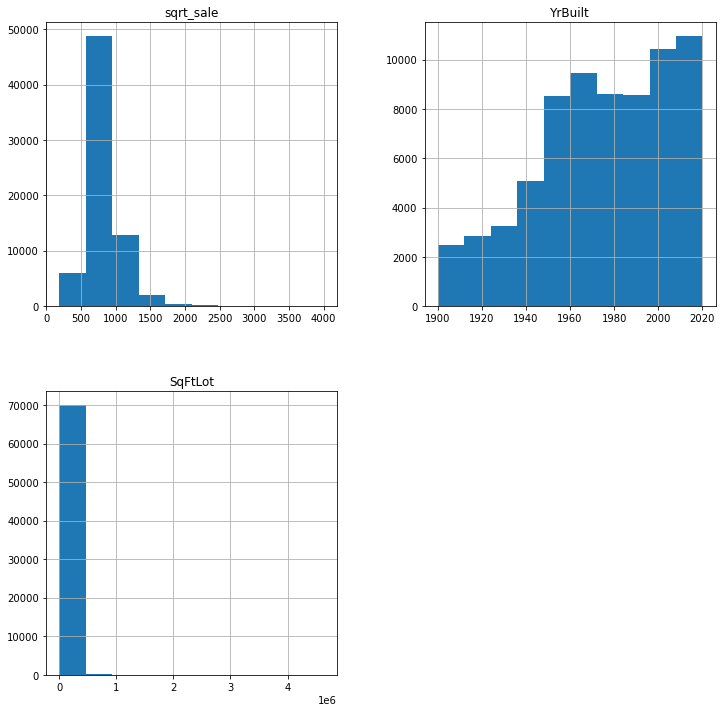

In [19]:
ResSale.hist(column = ['sqrt_sale', 'YrBuilt', 'SqFtLot'], 
             figsize = [12, 12]);

### Note:
 - Square foot lot space is skewed to the right
 - Will try log and square root transformations

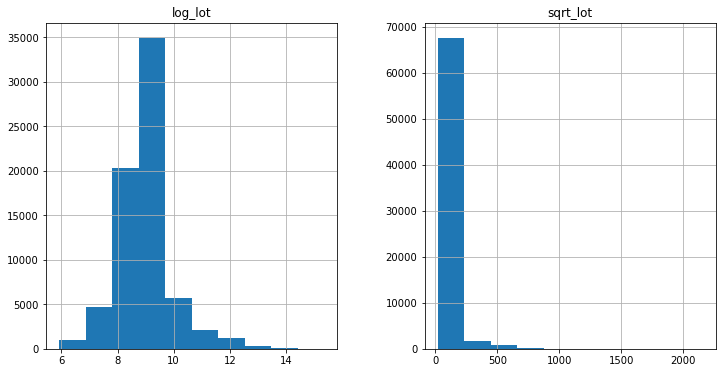

In [20]:
# Log transform of data
ResSale['log_lot'] = np.log(ResSale.SqFtLot)

# SQRT of data
ResSale['sqrt_lot'] = np.sqrt(ResSale.SqFtLot)

ResSale.hist(column = ['log_lot', 'sqrt_lot'],
                      figsize = [12, 6]);

### Note:
 - Log appears to normalize square foot lot

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                 2.180e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:56:40   Log-Likelihood:            -4.6887e+05
No. Observations:               70192   AIC:                         9.377e+05
Df Residuals:                   70189   BIC:                         9.378e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     137.7712      3.369     40.890      

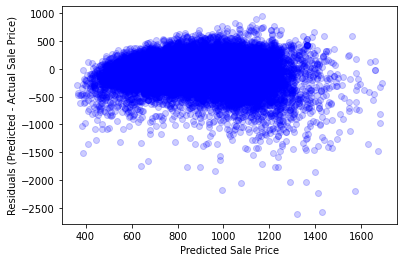

In [21]:
y = 'sqrt_sale'
X = ['sqrt_living', 'SqFtLot']
fx.create_model(ResSale, y, X)

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                 2.254e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:56:41   Log-Likelihood:            -4.6841e+05
No. Observations:               70192   AIC:                         9.368e+05
Df Residuals:                   70189   BIC:                         9.369e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     326.6993      7.023     46.517      

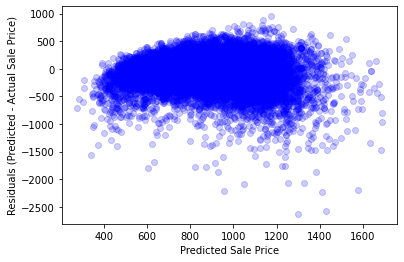

In [22]:
y = 'sqrt_sale'
X = ['sqrt_living', 'log_lot']
fx.create_model(ResSale, y, X)

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                 2.193e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:56:43   Log-Likelihood:            -4.6878e+05
No. Observations:               70192   AIC:                         9.376e+05
Df Residuals:                   70189   BIC:                         9.376e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     141.5317      3.369     42.005      

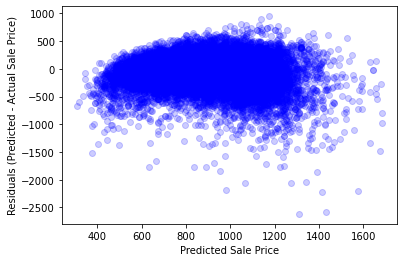

In [23]:
y = 'sqrt_sale'
X = ['sqrt_living', 'sqrt_lot']
fx.create_model(ResSale, y, X)

                            OLS Regression Results                            
Dep. Variable:              sqrt_sale   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                 2.320e+04
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:56:44   Log-Likelihood:            -4.6802e+05
No. Observations:               70192   AIC:                         9.360e+05
Df Residuals:                   70189   BIC:                         9.361e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2149.5560     48.297     44.507      

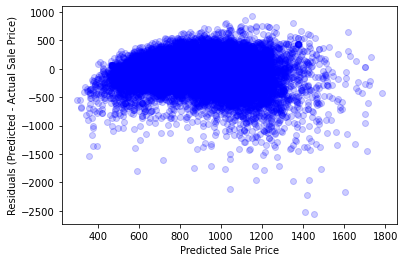

In [24]:
y = 'sqrt_sale'
X = ['sqrt_living', 'YrBuilt']
fx.create_model(ResSale, y, X)

### Notes re models with negatively correlated data:
 - All models are statistically significant and have coefficients that are statistically significant
 - VIFs are greater than 5 for log_lot and YrBuilt, so those models are violating the independence assumption.
  - Heat map indicated that YrBuilt was correlated with living space which may be why adding YrBuilt violates the independence assumption
 - Untransformed lot size has a very small coefficient, so its impact on sale price is too insignificant to be worthwhile
 - Including square root of lot size appears to be the best model, but R-squared only increased from 0.383 to 0.385, and each additionsl square foot of lot size decreases sale price by \$0.01
 
## Second Base Model Evaluation (square root of sale price, living space and lot size)
$ \sqrt{sale price} = {\beta}_{0} + {\beta}_{1}\sqrt{living} + {\beta}_{2}\sqrt{lot}$
 - R-squared is 0.385, so the model explains 38.5% of the variance in Sale Price
     - Adding the second feature only increased R-squared from 0.383 to 0.385
 - Overall p-value is 0.00, so the model is statistically significant at an alpha of 0.05
 - Property with 0 square feet of living space and 0 square foot lot is expected to sell for \$20,031
     - Note: since the model uses the square root of sale price, the intercept was squared to determine this value
 - For each additional square footage of living space, we expect the sale price to increase by \$239 
     - because each additional square root of living space increases the square root of the sales price by \$15.4667
 - For each additional square footage of lot space, we expect the sale price to decrease by \$0.02
 - p-values for intercept and slope are significant at an alpha of 0.05.  Thus, this model finds that the relationship between sale price and square footage of living space is significant

### Assumptions of Linear Regression:
***Linearity***
The null hypothesis is that the model is linearly predicted by the features.  The alternative hypothesis is that it is not.  Thus returning a high Rainbow p-value means that the current model does not violate the linearity assumption

***Normality***
The null hypothesis is that the residuals are normally distributed.  The alternative hypothesis is that they are not.  Thus returning a p-value of 0 under the Jarque-Bera test means that the current model violates the normality assumption.

***Homoscadasticity***
The null hypothesis is homoscedasticity.  The alternative hypothesis is heteroscedasticity.  Thus returning a low F-statistic p-value means that the current model violates the homoscedasticity assumption.

***Independence***
The independence assumptions means that the independent variables must not be too collinear.  Since we currently only have one independent variable, independence is not an issue.
